In [5]:
import asyncio
import subprocess
import io

from PIL import Image
import numpy as np
from pyotritonclient import execute
from kaibu_utils import fetch_image

In [9]:
def scale_to_uint8(array):
    """Given an input array, convert to uint8, including scaling to fill the
    0-255 range.

    Primarily used to convert general numpy arrays into an image rendering
    suitable dtype."""

    scaled = array.astype(np.float32)

    if scaled.max() - scaled.min() == 0:
        return np.zeros(array.shape, dtype=np.uint8)

    scaled = 255 * (scaled - scaled.min()) / (scaled.max() - scaled.min())

    return scaled.astype(np.uint8)

In [30]:
import zarr
import dask.array as da

def remote_zarr_to_cellpose_input(ome_zarr_uri):
    """Makes many bad assumptions about shape."""
    
    zgroup = zarr.open(ome_zarr_uri)
    zarray = zgroup['0']    

    darray = da.from_zarr(zarray)

    cellpose_ready = darray[0,:,0,:,:].astype('float32').compute()

    return cellpose_ready

In [31]:
async def predict_cellpose_masks(cellpose_ready, param):
    results = await execute([cellpose_ready, param],
                      server_url="https://hypha.bioimage.io/triton",
                      # model_name="stardist",
                      model_name="cellpose-python",
                          decode_bytes=True)
    
    mask = results["mask"]

    return mask

In [32]:
import skimage

def visualise_input_array_and_mask(input_array, mask):
    transposed = cellpose_input.transpose(1, 2, 0)
    padded_to_rgb = np.pad(transposed, pad_width=[(0, 0), (0, 0), (0, 1)])
    image_uint8 = scale_to_uint8(padded_to_rgb)
    mask_uint8 = scale_to_uint8(mask[0,:,:])

    return Image.fromarray(scale_to_uint8(skimage.segmentation.mark_boundaries(image_uint8, mask_uint8, color=[0,1,1])))

In [33]:
# ome_zarr_uri = "https://uk1s3.embassy.ebi.ac.uk/bia-zarr-test/S-BIAD144/IM1.zarr/0"
ome_zarr_uri = "https://uk1s3.embassy.ebi.ac.uk/bia-integrator-data/S-BIAD144/IM4/IM4.zarr/0"

In [34]:
cellpose_input = remote_zarr_to_cellpose_input(ome_zarr_uri)

In [ ]:
Image.fromarray(scale_to_uint8(cellpose_input[0,:,:]))

In [38]:
predicted_mask = await predict_cellpose_masks(cellpose_input, param = {"diameter": 120, "model_type": "cyto"})

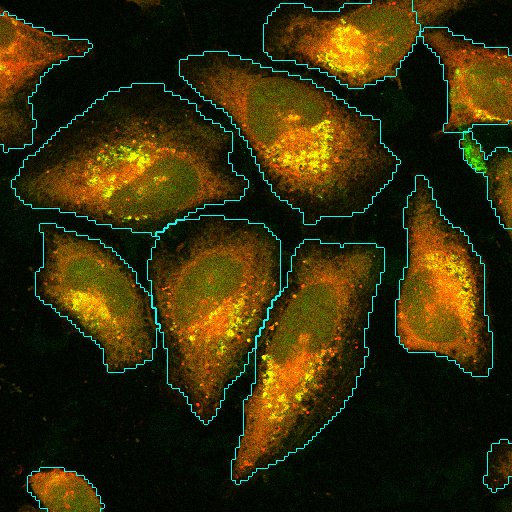

In [39]:
visualise_input_array_and_mask(cellpose_input, predicted_mask)